# IRIS-DETECTION

In [2]:
!pip install tensorflow  opencv-python matplotlib

  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)


In [8]:
import os
import cv2
import tensorflow as tf
import json 
import numpy as np
import matplotlib.pyplot as plt

# Loading the data

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [11]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [12]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

# preparing the labels

In [13]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [14]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))


In [15]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [16]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

# combining the labels with the images

In [17]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [18]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [19]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

# view sample

In [35]:
data_samples = train.as_numpy_iterator()

In [36]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


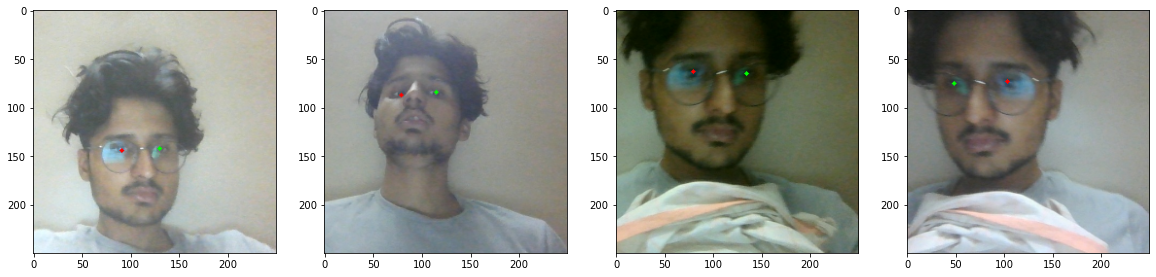

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# Model building 

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [21]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

234545216/234545216 [==============================] - 121s 1us/step


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

# Setup Losses and Optimizer

In [24]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [25]:
model.compile(optimizer, loss)


#  Sense Check predictions

In [26]:
X, y = train.as_numpy_iterator().next()

In [27]:
X.shape

(16, 250, 250, 3)

In [28]:
scores = model.predict(X)

1/1 [==============================] - 6s 6s/step


In [29]:
scores

array([[-0.69018734, -0.42720917,  0.28709668,  0.14855298],
       [-0.3727636 , -0.99072397,  0.8887416 ,  0.653967  ],
       [-1.0246992 ,  0.20327425,  1.1013043 ,  0.884835  ],
       [-1.1329451 , -0.43989834,  0.37391207, -0.01452327],
       [-0.65798146, -0.63913053,  1.1149509 ,  0.46874127],
       [-1.9669598 , -1.0094538 ,  0.23515165, -0.55336165],
       [-0.5001246 ,  0.91664535,  1.2015386 ,  0.36943445],
       [-0.12601556, -0.97924405,  1.103348  ,  0.20129243],
       [-0.39465922, -0.2641027 ,  0.6996794 ,  0.14228858],
       [-0.8228091 , -0.2838733 ,  1.3068699 ,  0.23735455],
       [-0.8305228 , -0.7707141 ,  0.7732542 ,  0.57214636],
       [-0.8415751 ,  0.20417476,  1.2045233 ,  0.92643595],
       [-0.8653082 , -0.8764065 ,  0.88606125,  1.1152005 ],
       [-1.100266  , -0.2537633 ,  0.8438876 ,  0.35070306],
       [-0.88932574, -0.56011033,  1.0921669 ,  0.15871114],
       [-0.16877332, -0.48999223,  0.90070313,  0.4842292 ]],
      dtype=float32)

# Training the Model

In [30]:
# Train for 100 epochs
hist = model.fit(train, epochs=1, validation_data=val)

237/237 [==============================] - 16732s 70s/step - loss: 0.6971 - val_loss: 0.0333


# Reviewing the performance

In [31]:
hist.history

{'loss': [0.6970537900924683], 'val_loss': [0.033313117921352386]}

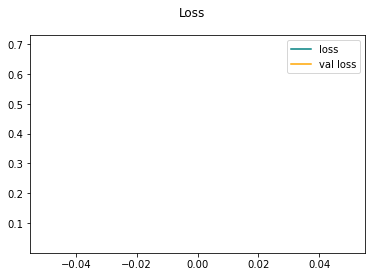

In [38]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

# making prediction on test

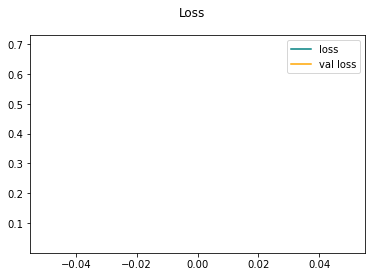

In [33]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

In [40]:
test_data = test.as_numpy_iterator()

In [41]:
test_sample = test_data.next()

In [42]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 11s 11s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


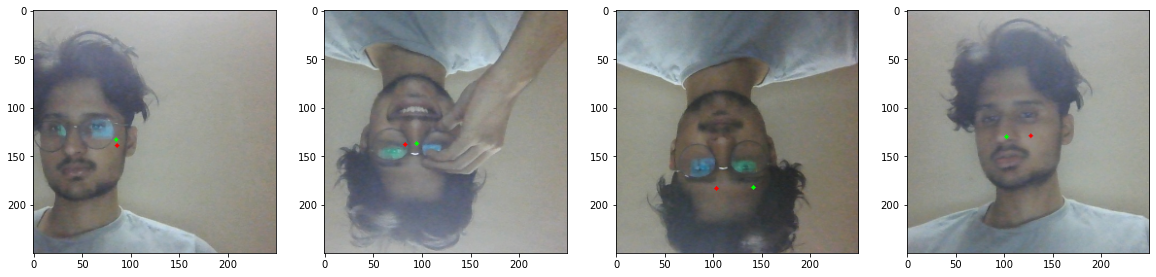

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

#  Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save('eyetrackerresnet.h5')


In [46]:
model = load_model('eyetrackerresnet.h5')

# Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()